In [1]:
%matplotlib inline


# Modeling Spectral Irradiance

Recreating Figure 5-1A from the SPECTRL2 NREL Technical Report.


This example shows how to model the spectral distribution of irradiance
based on atmospheric conditions. The spectral distribution of irradiance is
the power content at each wavelength band in the solar spectrum and is
affected by various scattering and absorption mechanisms in the atmosphere.
This example recreates an example figure from the SPECTRL2 NREL Technical
Report [1]_. The figure shows modeled spectra at hourly intervals across
a single morning.

## References
.. [1] Bird, R, and Riordan, C., 1984, "Simple solar spectral model for
   direct and diffuse irradiance on horizontal and tilted planes at the
   earth's surface for cloudless atmospheres", NREL Technical Report
   TR-215-2436 doi:10.2172/5986936.



The SPECTRL2 model has several inputs; some can be calculated with pvlib,
but other must come from a weather dataset. In this case, these weather
parameters are example assumptions taken from the technical report.



In [2]:
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pandas as pd
import matplotlib.pyplot as plt

# assumptions from the technical report:
lat = 37
lon = -100
tilt = 37
azimuth = 180
pressure = 101300  # sea level, roughly
water_vapor_content = 0.5  # cm
tau500 = 0.1
ozone = 0.31  # atm-cm
albedo = 0.2

times = pd.date_range('1984-03-20 06:17', freq='h', periods=6, tz='Etc/GMT+7')
solpos = solarposition.get_solarposition(times, lat, lon)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# The technical report uses the 'kasten1966' airmass model, but later
# versions of SPECTRL2 use 'kastenyoung1989'.  Here we use 'kasten1966'
# for consistency with the technical report.
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                   model='kasten1966')

With all the necessary inputs in hand we can model spectral irradiance using
:py:func:`pvlib.spectrum.spectrl2`.  Note that because we are calculating
the spectra for more than one set of conditions, we will get back 2-D
arrays (one dimension for wavelength, one for time).



In [3]:
spectra = spectrum.spectrl2(
    apparent_zenith=solpos.apparent_zenith,
    aoi=aoi,
    surface_tilt=tilt,
    ground_albedo=albedo,
    surface_pressure=pressure,
    relative_airmass=relative_airmass,
    precipitable_water=water_vapor_content,
    ozone=ozone,
    aerosol_turbidity_500nm=tau500,
)

The ``poa_global`` array represents the total spectral irradiance on our
hypothetical solar panel. Let's plot it against wavelength to recreate
Figure 5-1A:



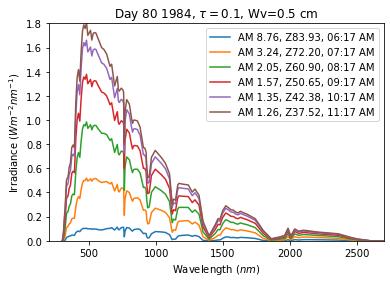

In [4]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(r"Day 80 1984, $\tau=0.1$, Wv=0.5 cm")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM {:0.02f}, Z{:0.02f}, {}".format(*vals)
    for vals in zip(relative_airmass, solpos.apparent_zenith, time_labels)
]
plt.legend(labels)
plt.show()

Note that the airmass and zenith values do not exactly match the values in
the technical report; this is because airmass is estimated from solar
position and the solar position calculation in the technical report does not
exactly match the one used here.  However, the differences are minor enough
to not materially change the spectra.

